## Imports

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from bitcoin_deep_learning.call_api import ApiCall
from bitcoin_deep_learning.model import RnnDlModel, LinearRegressionBaselineModel, DummyModel, RandomForestReg, RnnDlModel_test 
from bitcoin_deep_learning.trainer import train, read_result
from bitcoin_deep_learning.cross_val import get_cross_XY
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
import joblib
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Getting data

In [3]:
train_df = ApiCall().read_local(data='train')#.drop(columns = '[%]_Bitcoin_growth_rate_on_Horizon=7')

In [4]:
X_train_list, Y_train_list, X_test_list,Y_test_list = get_cross_XY()

In [5]:
np.array(X_train_list).shape

(32, 263, 90, 32)

In [6]:
train_df.head(3)

date  [AVG]_[NH]_mean_hash_rate  [+]_[NH]_Days_Till_Halving  \
0  2018-02-01               2.054109e+19                         830   
1  2018-02-02               2.170824e+19                         829   
2  2018-02-03               2.073919e+19                         828   

   [//]_[AV]_Stock-to-Flow_Ratio  [+]_[NH]_Circulating_Supply  \
0                    5642.903220                   16839700.0   
1                    5641.695528                   16841800.0   
2                    5641.015128                   16843775.0   

   [+]_[NH]_Issuance  [+]_[NH]_Number_of_Active_Addresses  \
0             2000.0                               842398   
1             2100.0                               854253   
2             1975.0                               714655   

   [+]_[NH]_Mean_Block_Interval  [+]_[NH]_Number_of_Transactions  \
0                           377                           257504   
1                           385                           235750   
2                           384                           194733   

   [+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance  ...  \
0                                           27026398     ...   
1                                           26955617     ...   
2                                           26886977     ...   

   [//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio  fear_greed_value  \
0                                         0.003691                30   
1                                         0.002557                15   
2                                         0.001970                40   

   [+]_[NH]_Number_of_Addresses_with_Balance_0.01 - 0.1  \
0                                            4226306      
1                                            4198274      
2                                            4173275      

   [+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1  \
0                                            1722331   
1                                            1704275   
2                                            1692828   

   [+]_[NH]_Number_of_Addresses_with_Balance_1 - 10  \
0                                            544769   
1                                            543489   
2                                            542447   

   [+]_[NH]_Number_of_Addresses_with_Balance_10 - 100  \
0                                             132314    
1                                             132213    
2                                             132021    

   [+]_[NH]_Number_of_Addresses_with_Balance_100 - 1k  \
0                                              15779    
1                                              15815    
2                                              15812    

   [+]_[NH]_Number_of_Addresses_with_Balance_1k - 10k  [+]_[T]_Bitcoin_Price  \
0                                               1529             9014.026207   
1                                               1521             8799.121911   
2                                               1523             9208.459919   

   [%]_Bitcoin_growth_rate_on_Horizon=7  
0                             -0.235616  
1                             -0.260491  
2                             -0.230759  

[3 rows x 33 columns]

## Data viz exploration

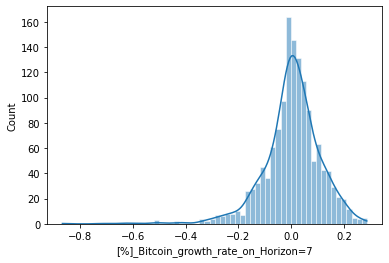

In [7]:
sns.histplot(train_df['[%]_Bitcoin_growth_rate_on_Horizon=7'], kde=True, edgecolor='w');

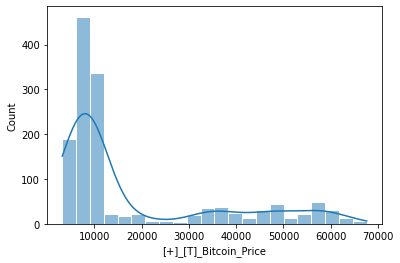

In [8]:
sns.histplot(train_df['[+]_[T]_Bitcoin_Price'], kde=True, edgecolor='w');

## Ploting models

### Plotting prediction per folds

In [9]:
def plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, model):
    fig, axs = plt.subplots(nrows = len(X_train_list), ncols = 2, figsize = (17,150))
    for k in range(len(X_train_list)):
        X_train, y_train, X_test, y_test = X_train_list[k], Y_train_list[k], X_test_list[k], Y_test_list[k]
        #intuition too much regularization on the lasso
        model.set_model()
        #model.fit(model.preproc(X_test, X_train)[1], y_train)
        y_pred = model.run(X_test, X_train, y_train)
        axs[k, 0].plot(y_test, label = 'test')
        axs[k, 0].plot(y_pred, color = 'r', label = 'pred')
        axs[k, 0].set_title('Fitting of y_test, y_pred')
        axs[k, 0].legend()
        axs[k, 1].plot(y_train, label = 'train', color = 'g')
        axs[k, 1].set_title('Evolution of the y_train')
        axs[k, 1].legend();

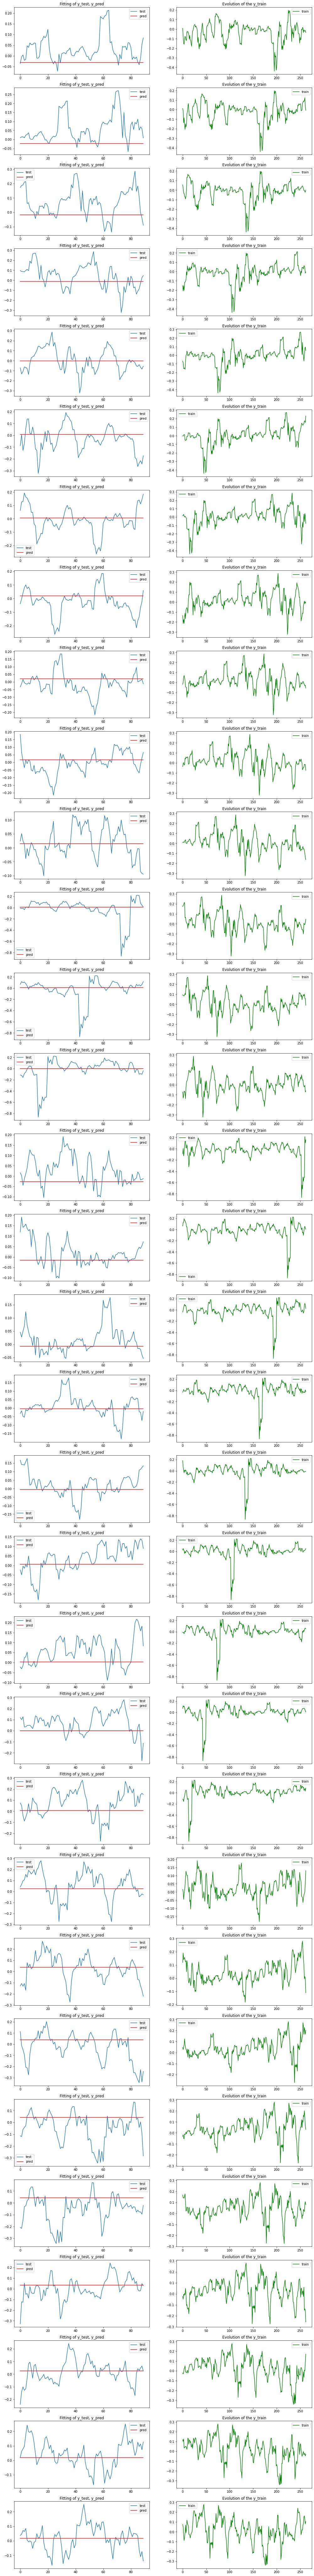

In [10]:
alpha = 15
l1 = 0.003
plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, LinearRegressionBaselineModel(alpha = alpha , l1_ratio = l1))

In [11]:
#ypred j+7 - ypred j+1 / ypred j+7
#ypred_diff.apply(lambda x: x*())

## Analysing Coefs

### Elastic Net training

In [12]:
model_regression = LinearRegressionBaselineModel(alpha = 15 , l1_ratio = 0.0001)
train(model_regression, train_df)
model_regression.model.coef_

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.88it/s]

Training done


array([-1.41490517e-04,  3.58676984e-04, -6.47379321e-04, -3.84141296e-04,
        0.00000000e+00, -4.90659691e-05, -0.00000000e+00,  4.51679217e-05,
       -6.67380378e-04,  4.23398077e-04,  4.54153240e-04, -3.98532447e-04,
       -0.00000000e+00, -5.08050421e-04,  1.14521781e-04, -3.05672341e-04,
        1.67760147e-05, -0.00000000e+00, -7.86606003e-04,  0.00000000e+00,
       -2.31355682e-05, -1.23008653e-04,  0.00000000e+00,  2.94856626e-04,
       -5.42433793e-04, -5.62178953e-04,  1.35403644e-04,  6.72121215e-04,
       -4.00115731e-04,  2.95050392e-04, -6.84278915e-04,  1.67619482e-05])

In [13]:
train_df_matrix = train_df.copy().drop(columns = 'date')
len(train_df_matrix.columns)

32

In [14]:
coeff_matrix = pd.DataFrame(zip(train_df_matrix.columns,model_regression.model.coef_))
coeff_matrix = coeff_matrix.rename(columns={0: "features", 1: "coeff"})
coeff_matrix_absolute = coeff_matrix.copy()
coeff_matrix_absolute['coeff abs'] = coeff_matrix['coeff'].apply(abs)
coeff_matrix_absolute = coeff_matrix_absolute.drop(columns = 'coeff')
coeff_matrix_absolute.sort_values(by = 'coeff abs', ascending = False).reset_index(drop = True)

features  coeff abs
0                            [$]_[BSB]_Realized_Price   0.000787
1                               [+]_[T]_Bitcoin_Price   0.000684
2   [+]_[NH]_Number_of_Addresses_with_Balance_10 -...   0.000672
3   [+]_[NH]_Number_of_Addresses_with_a_Non-Zero_B...   0.000667
4                       [//]_[AV]_Stock-to-Flow_Ratio   0.000647
5   [+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1   0.000562
6   [+]_[NH]_Number_of_Addresses_with_Balance_0.01...   0.000542
7                               [//]_[BSB]_Liveliness   0.000508
8   [%]_[BSB]_Percent_of_Supply_Last_Active_1+_Yea...   0.000454
9     [+]_[NH]_Number_of_Addresses_with_Balance_≥_10k   0.000423
10  [+]_[NH]_Number_of_Addresses_with_Balance_100 ...   0.000400
11                     [//]_[BSB]_Realized_HODL_Ratio   0.000399
12                        [+]_[NH]_Circulating_Supply   0.000384
13                         [+]_[NH]_Days_Till_Halving   0.000359
14  [$]_[BSB]_Exchange_Net_Position_Change_-_All_E...   0.000306
15  [+]_[NH]_Number_of_Addresses_with_Balance_1k -...   0.000295
16                                   fear_greed_value   0.000295
17                          [AVG]_[NH]_mean_hash_rate   0.000141
18   [+]_[NH]_Number_of_Addresses_with_Balance_1 - 10   0.000135
19                           [//]_[AV]_Puell_Multiple   0.000123
20  [%]_[BSB]_Percent_Balance_on_Exchanges_-_All_E...   0.000115
21                [+]_[NH]_Number_of_Active_Addresses   0.000049
22                    [+]_[NH]_Number_of_Transactions   0.000045
23  [//]_[AV]_Market_Value_to_Realized_Value_Ratio...   0.000023
24              [//]_[BSB]_Realized_Profit/Loss_Ratio   0.000017
25               [%]_Bitcoin_growth_rate_on_Horizon=7   0.000017
26    [//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio   0.000000
27                  [%]_[BSB]_Price_Drawdown_from_ATH   0.000000
28        [$]_[BSB]_Net_Unrealized_Profit/Loss_(NUPL)   0.000000
29   [AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL)   0.000000
30                       [+]_[NH]_Mean_Block_Interval   0.000000
31                                  [+]_[NH]_Issuance   0.000000

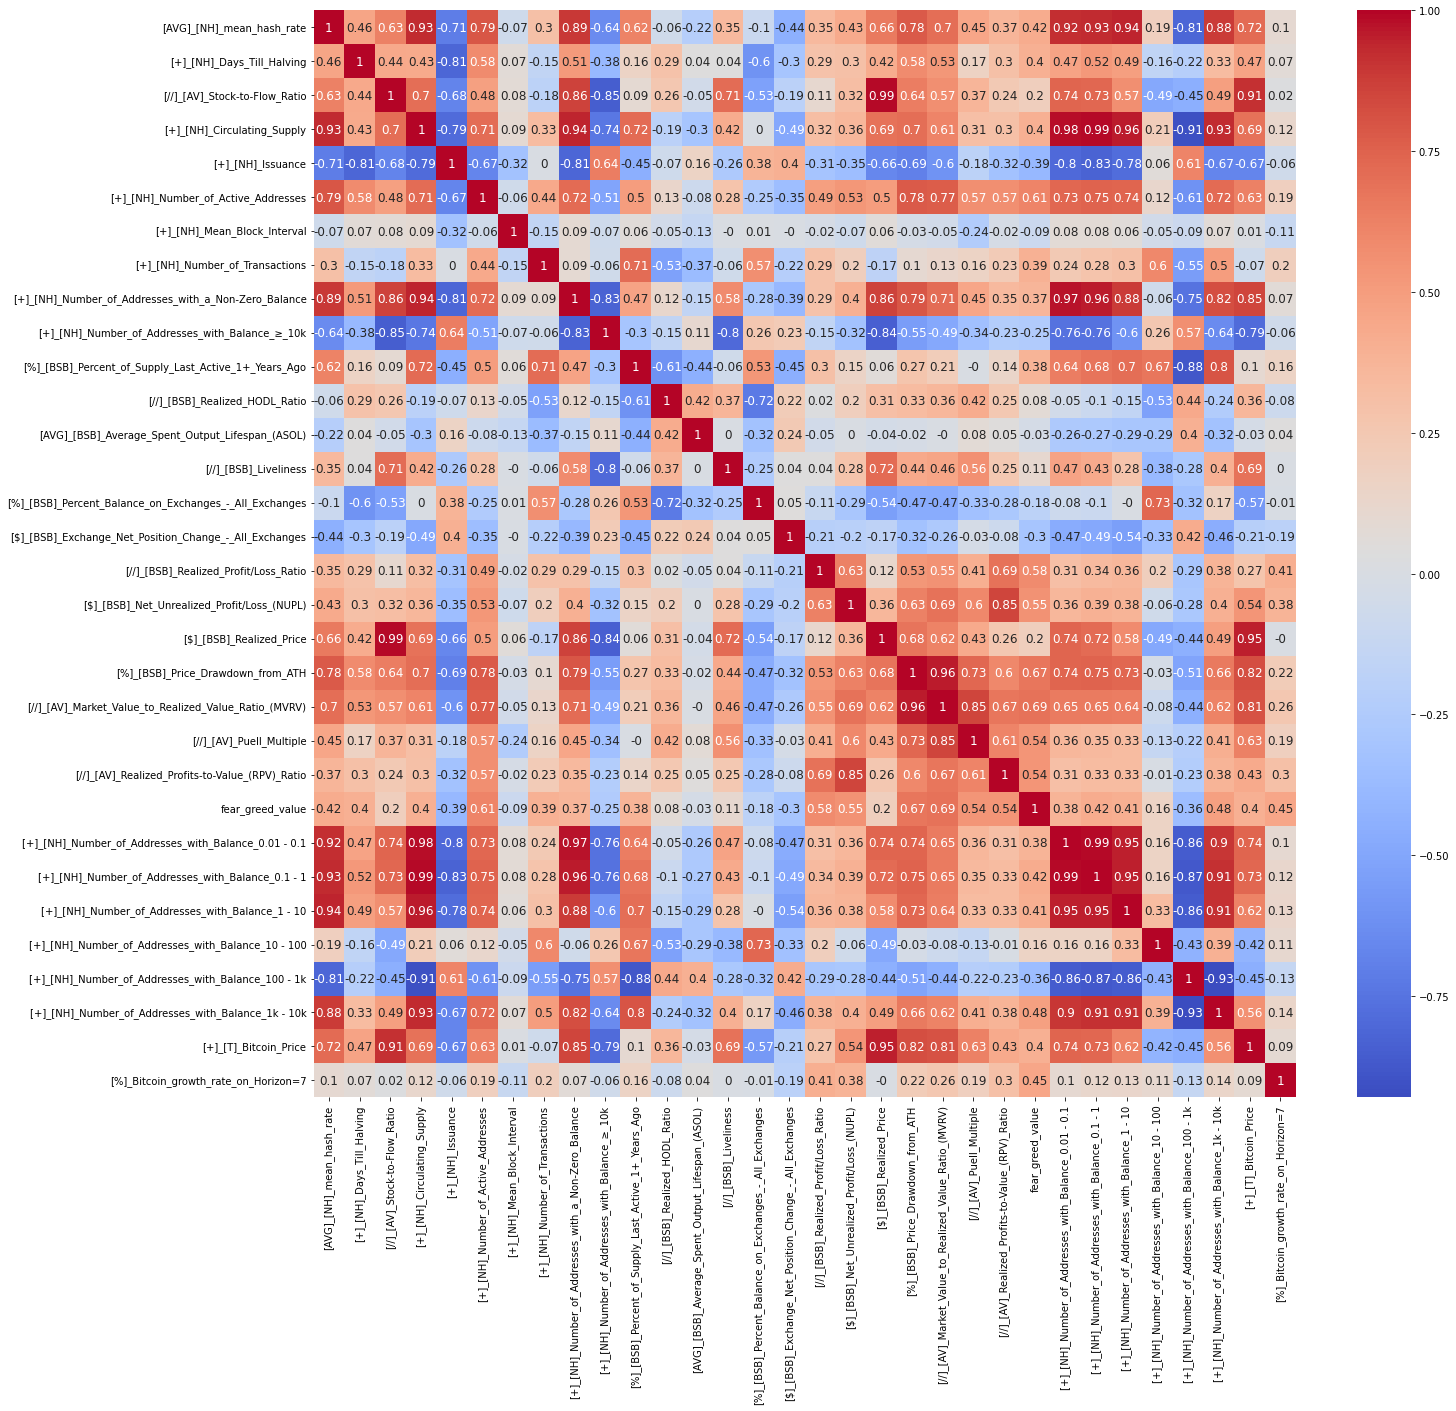

In [15]:
plt.figure(figsize = (22,20))
sns.heatmap(round(train_df_matrix.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12});

In [16]:
train_df_matrix.corr().style.background_gradient(cmap='coolwarm')

### VIF index

In [17]:
train_df_nodates = train_df.copy().drop(columns = 'date')#.drop(columns = bucket_list)

In [18]:
train_df_nodates_scaled = train_df_nodates.copy()

for feature in train_df_nodates_scaled.columns:
    mu = train_df_nodates[feature].mean()
    sigma = train_df_nodates[feature].std()
    train_df_nodates_scaled[feature] = train_df_nodates_scaled[feature].apply(lambda x: (x-mu)/sigma)

In [19]:
df = pd.DataFrame()

df["features"] = train_df_nodates_scaled.columns

df["vif_index"] = [vif(train_df_nodates_scaled.values, i) for i in range(train_df_nodates_scaled.shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2).reset_index(drop = True)

features  vif_index
0                         [+]_[NH]_Circulating_Supply     541.09
1                            [$]_[BSB]_Realized_Price     457.67
2                       [//]_[AV]_Stock-to-Flow_Ratio     290.22
3   [+]_[NH]_Number_of_Addresses_with_Balance_0.01...     276.45
4   [+]_[NH]_Number_of_Addresses_with_a_Non-Zero_B...     257.74
5   [+]_[NH]_Number_of_Addresses_with_Balance_0.1 - 1     237.33
6                               [+]_[T]_Bitcoin_Price     172.11
7   [//]_[AV]_Market_Value_to_Realized_Value_Ratio...     163.09
8    [+]_[NH]_Number_of_Addresses_with_Balance_1 - 10     100.08
9                   [%]_[BSB]_Price_Drawdown_from_ATH      79.25
10                           [//]_[AV]_Puell_Multiple      57.13
11                          [AVG]_[NH]_mean_hash_rate      52.13
12  [+]_[NH]_Number_of_Addresses_with_Balance_1k -...      50.72
13  [%]_[BSB]_Percent_Balance_on_Exchanges_-_All_E...      47.02
14  [%]_[BSB]_Percent_of_Supply_Last_Active_1+_Yea...      45.37
15  [+]_[NH]_Number_of_Addresses_with_Balance_100 ...      34.52
16                                  [+]_[NH]_Issuance      31.23
17    [+]_[NH]_Number_of_Addresses_with_Balance_≥_10k      25.97
18  [+]_[NH]_Number_of_Addresses_with_Balance_10 -...      21.98
19                              [//]_[BSB]_Liveliness      19.81
20                         [+]_[NH]_Days_Till_Halving      15.50
21                     [//]_[BSB]_Realized_HODL_Ratio      11.12
22                [+]_[NH]_Number_of_Active_Addresses      10.94
23                    [+]_[NH]_Number_of_Transactions       9.14
24    [//]_[AV]_Realized_Profits-to-Value_(RPV)_Ratio       7.32
25        [$]_[BSB]_Net_Unrealized_Profit/Loss_(NUPL)       7.06
26                                   fear_greed_value       5.51
27  [$]_[BSB]_Exchange_Net_Position_Change_-_All_E...       3.72
28              [//]_[BSB]_Realized_Profit/Loss_Ratio       2.82
29                       [+]_[NH]_Mean_Block_Interval       2.34
30               [%]_Bitcoin_growth_rate_on_Horizon=7       1.86
31   [AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL)       1.76

## Grid search and training

### Dummy model instanciating

In [20]:
# Instanciate model
dummy_model = DummyModel()
# Train and Fit data using the crossval
val_score,score = train(dummy_model,train_df);
print(val_score,score)

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 35.32it/s]

Training done
[0.06752, 0.08603, 0.11788, 0.13216, 0.14218, 0.13137, 0.11836, 0.10211, 0.09112, 0.07741, 0.06885, 0.16989, 0.18129, 0.19172, 0.08736, 0.06533, 0.05455, 0.06516, 0.0715, 0.06928, 0.07938, 0.10269, 0.12339, 0.1378, 0.13358, 0.15056, 0.13907, 0.14184, 0.12797, 0.11073, 0.10906, 0.09107] 0.11057


### Elastic Net Tuning

In [21]:
# Instanciate Grid Search
for counter in range(20):
    alpha = 0.015 * random()
    l1 = 0.002
    # Instanciate model
    regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
    # Train and Fit data using the crossval
    train(regression_model,train_df);

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.17it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 30.77it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 26.04it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.97it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 30.09it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 28.93it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 27.32it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 29.32it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 27.95it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 31.36it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 31.34it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 31.63it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 23.41it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 31.88it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 31.59it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 31.76it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 32.97it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 24.55it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 22.19it/s]


Training done


100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 24.89it/s]

Training done


In [70]:
alpha = 15
l1 = 0.003
# Instanciate model
regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
# Train and Fit data using the crossval
train(regression_model,train_df);

100%|███████████████████████████████████████████| 32/32 [00:00<00:00, 36.13it/s]

Training done


### RNN Tuning

In [1]:
# Instanciate Grid Search
for counter in range(1):
    l1_rnn = random() / 10
    l2_rnn = random() / 10
    # Instanciate model
    rnn_model = RnnDlModel(L1 = l1_rnn, L2 = l2_rnn, epochs = 20, patience = 5)
    # Train and Fit data using the crossval
    fold_score, score = train(rnn_model,train_df);

NameError: name 'random' is not defined

2022-03-09 12:33:05.665319: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-09 12:33:05.750103: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
4/4 [==============================] - 1s 61ms/step - loss: 0.0152 - mae: 0.0967 - val_loss: 0.0136 - val_mae: 0.0946
Epoch 2/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0106 - mae: 0.0844 - val_loss: 0.0132 - val_mae: 0.0934
Epoch 3/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0098 - mae: 0.0812 - val_loss: 0.0122 - val_mae: 0.0896
Epoch 4/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0094 - mae: 0.0783 - val_loss: 0.0123 - val_mae: 0.0901
Epoch 5/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0089 - mae: 0.0756 - val_loss: 0.0112 - val_mae: 0.0857
Epoch 6/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0082 - mae: 0.0701 - val_loss: 0.0131 - val_mae: 0.0935
Epoch 7/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0079 - mae: 0.0696 - val_loss: 0.0158 - val_mae: 0.1038
Epoch 8/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0081 - mae: 0.0707 - val

Epoch 1/20
4/4 [==============================] - 1s 52ms/step - loss: 0.0295 - mae: 0.1286 - val_loss: 0.0268 - val_mae: 0.1443
Epoch 2/20
4/4 [==============================] - 0s 19ms/step - loss: 0.0096 - mae: 0.0661 - val_loss: 0.0192 - val_mae: 0.1197
Epoch 3/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0075 - mae: 0.0599 - val_loss: 0.0112 - val_mae: 0.0880
Epoch 4/20
4/4 [==============================] - 0s 19ms/step - loss: 0.0083 - mae: 0.0658 - val_loss: 0.0215 - val_mae: 0.1262
Epoch 5/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0066 - mae: 0.0573 - val_loss: 0.0220 - val_mae: 0.1271
Epoch 6/20
4/4 [==============================] - 0s 19ms/step - loss: 0.0060 - mae: 0.0559 - val_loss: 0.0312 - val_mae: 0.1569
Epoch 7/20
4/4 [==============================] - 0s 21ms/step - loss: 0.0066 - mae: 0.0606 - val_loss: 0.0121 - val_mae: 0.0903
Epoch 8/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0075 - mae: 0.0661 - val

Epoch 4/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0131 - mae: 0.0885 - val_loss: 0.0045 - val_mae: 0.0520
Epoch 5/20
4/4 [==============================] - 0s 19ms/step - loss: 0.0101 - mae: 0.0783 - val_loss: 0.0100 - val_mae: 0.0824
Epoch 6/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0095 - mae: 0.0753 - val_loss: 0.0044 - val_mae: 0.0513
Epoch 7/20
4/4 [==============================] - 0s 22ms/step - loss: 0.0093 - mae: 0.0734 - val_loss: 0.0150 - val_mae: 0.1055
Epoch 8/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0108 - mae: 0.0803 - val_loss: 0.0046 - val_mae: 0.0534
Epoch 9/20
4/4 [==============================] - 0s 19ms/step - loss: 0.0098 - mae: 0.0775 - val_loss: 0.0047 - val_mae: 0.0519
Epoch 10/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0084 - mae: 0.0712 - val_loss: 0.0106 - val_mae: 0.0851
Epoch 11/20
4/4 [==============================] - 0s 19ms/step - loss: 0.0098 - mae: 0.0761 - v

4/4 [==============================] - 0s 20ms/step - loss: 0.0048 - mae: 0.0532 - val_loss: 0.0616 - val_mae: 0.1433
Epoch 13/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0046 - mae: 0.0513 - val_loss: 0.0652 - val_mae: 0.1479
Epoch 14/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0046 - mae: 0.0509 - val_loss: 0.0541 - val_mae: 0.1365
Epoch 15/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0046 - mae: 0.0508 - val_loss: 0.0605 - val_mae: 0.1418
Epoch 16/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0045 - mae: 0.0503 - val_loss: 0.0629 - val_mae: 0.1446
Epoch 17/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0044 - mae: 0.0498 - val_loss: 0.0604 - val_mae: 0.1418
Epoch 18/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0043 - mae: 0.0490 - val_loss: 0.0536 - val_mae: 0.1342
Epoch 19/20
4/4 [==============================] - 0s 21ms/step - loss: 0.0047 - mae: 0.0530 - val_los

4/4 [==============================] - 0s 20ms/step - loss: 0.0162 - mae: 0.0706 - val_loss: 0.0130 - val_mae: 0.0955
Epoch 7/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0167 - mae: 0.0773 - val_loss: 0.0072 - val_mae: 0.0652
Epoch 8/20
4/4 [==============================] - 0s 22ms/step - loss: 0.0157 - mae: 0.0678 - val_loss: 0.0065 - val_mae: 0.0603
Epoch 9/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0144 - mae: 0.0656 - val_loss: 0.0042 - val_mae: 0.0471
Epoch 10/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0162 - mae: 0.0740 - val_loss: 0.0046 - val_mae: 0.0494
Epoch 11/20
4/4 [==============================] - 0s 19ms/step - loss: 0.0136 - mae: 0.0624 - val_loss: 0.0045 - val_mae: 0.0490
Epoch 12/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0138 - mae: 0.0703 - val_loss: 0.0044 - val_mae: 0.0479
Epoch 13/20
4/4 [==============================] - 0s 19ms/step - loss: 0.0138 - mae: 0.0699 - val_loss: 

4/4 [==============================] - 0s 20ms/step - loss: 0.0046 - mae: 0.0510 - val_loss: 0.0159 - val_mae: 0.1039
Epoch 9/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0038 - mae: 0.0465 - val_loss: 0.0170 - val_mae: 0.1045
Epoch 10/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0039 - mae: 0.0483 - val_loss: 0.0185 - val_mae: 0.1063
Epoch 11/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0048 - mae: 0.0540 - val_loss: 0.0204 - val_mae: 0.1089
Epoch 12/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0044 - mae: 0.0508 - val_loss: 0.0186 - val_mae: 0.1066
Epoch 13/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0043 - mae: 0.0506 - val_loss: 0.0171 - val_mae: 0.1055
Epoch 1/20
4/4 [==============================] - 1s 55ms/step - loss: 0.0265 - mae: 0.1255 - val_loss: 0.0232 - val_mae: 0.1258
Epoch 2/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0081 - mae: 0.0717 - val_loss: 

4/4 [==============================] - 0s 21ms/step - loss: 0.0117 - mae: 0.0867 - val_loss: 0.0088 - val_mae: 0.0672
Epoch 6/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0115 - mae: 0.0845 - val_loss: 0.0078 - val_mae: 0.0630
Epoch 7/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0112 - mae: 0.0838 - val_loss: 0.0090 - val_mae: 0.0681
Epoch 8/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0112 - mae: 0.0828 - val_loss: 0.0093 - val_mae: 0.0698
Epoch 9/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0113 - mae: 0.0825 - val_loss: 0.0083 - val_mae: 0.0659
Epoch 1/20
4/4 [==============================] - 1s 53ms/step - loss: 0.0169 - mae: 0.0998 - val_loss: 0.0114 - val_mae: 0.0824
Epoch 2/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0150 - mae: 0.1004 - val_loss: 0.0098 - val_mae: 0.0763
Epoch 3/20
4/4 [==============================] - 0s 20ms/step - loss: 0.0135 - mae: 0.0950 - val_loss: 0.01

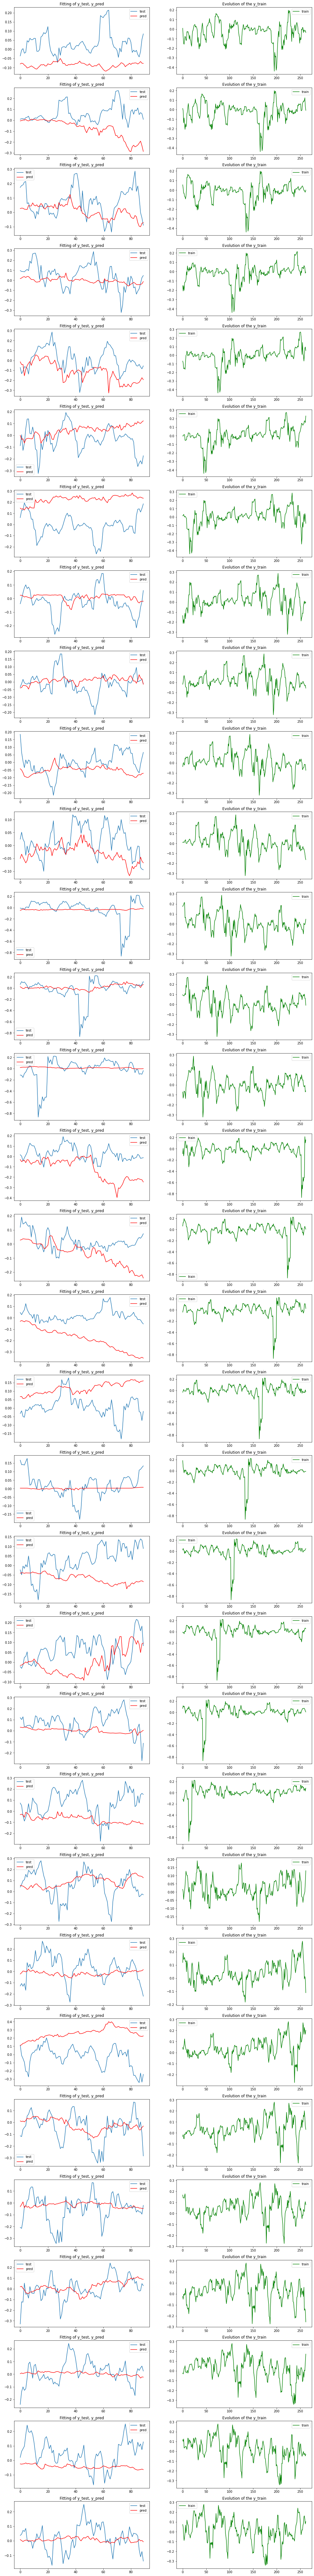

In [25]:
l1_rnn = 0.01653480436240602
l2_rnn = 0.0792386474

plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, RnnDlModel_test(L1 = l1_rnn, L2 = l2_rnn, epochs = 20, patience = 5))



### Exporting and viewing results

In [26]:
df_result = read_result()
df_result = df_result.sort_values(by="mean_score", ascending = True)
df_result

name                                         fold_score  mean_score  \
20  LinearReg  [0.06422, 0.08158, 0.10233, 0.10397, 0.0928, 0...     0.08007   
21      Dummy  [0.06752, 0.08603, 0.11788, 0.13216, 0.14218, ...     0.11057   
10  LinearReg  [0.13612, 0.21353, 0.30214, 0.10699, 0.19859, ...     0.16727   
38  LinearReg  [0.13771, 0.21647, 0.30717, 0.10733, 0.20077, ...     0.16939   
25  LinearReg  [0.13809, 0.21718, 0.30844, 0.1074, 0.20131, 0...     0.16991   
17  LinearReg  [0.14206, 0.22432, 0.32162, 0.10804, 0.20692, ...     0.17525   
11  LinearReg  [0.14258, 0.22526, 0.32338, 0.10813, 0.20769, ...     0.17597   
14  LinearReg  [0.14356, 0.22703, 0.32675, 0.10832, 0.20915, ...     0.17733   
7   LinearReg  [0.14811, 0.23535, 0.34311, 0.10916, 0.21625, ...     0.18392   
22  LinearReg  [0.1485, 0.23608, 0.34458, 0.10923, 0.21689, 0...     0.18452   
18  LinearReg  [0.15123, 0.24124, 0.35522, 0.10981, 0.2216, 0...     0.18882   
6   LinearReg  [0.15154, 0.24184, 0.3565, 0.10987, 0.22217, 0...     0.18933   
4   LinearReg  [0.15219, 0.24308, 0.35915, 0.10999, 0.22336, ...     0.19040   
5   LinearReg  [0.15304, 0.24473, 0.36273, 0.11016, 0.225, 0....     0.19182   
35  LinearReg  [0.15322, 0.24509, 0.3635, 0.1102, 0.22536, 0....     0.19213   
16  LinearReg  [0.15433, 0.24688, 0.36744, 0.1104, 0.22718, 0...     0.19370   
36  LinearReg  [0.15546, 0.2487, 0.37153, 0.11062, 0.22909, 0...     0.19534   
15  LinearReg  [0.15629, 0.25013, 0.37476, 0.11079, 0.23062, ...     0.19664   
37  LinearReg  [0.15643, 0.25039, 0.37538, 0.11083, 0.23091, ...     0.19689   
33  LinearReg  [0.15746, 0.25253, 0.38032, 0.11109, 0.23331, ...     0.19889   
2   LinearReg  [0.15875, 0.25477, 0.38564, 0.11137, 0.23592, ...     0.20103   
12  LinearReg  [0.1602, 0.25723, 0.39163, 0.11171, 0.23892, 0...     0.20345   
31  LinearReg  [0.16138, 0.26, 0.39859, 0.11209, 0.24247, 0.3...     0.20624   
32  LinearReg  [0.1615, 0.26027, 0.39929, 0.11213, 0.24283, 0...     0.20652   
3   LinearReg  [0.16197, 0.26144, 0.40232, 0.11229, 0.24441, ...     0.20774   
0   LinearReg  [0.16269, 0.2633, 0.40722, 0.11255, 0.24699, 0...     0.20971   
23  LinearReg  [0.1644, 0.26967, 0.4212, 0.11325, 0.25466, 0....     0.21532   
26  LinearReg  [0.16589, 0.27603, 0.44034, 0.11413, 0.26599, ...     0.22293   
8   LinearReg  [0.1662, 0.28163, 0.45969, 0.11494, 0.27859, 0...     0.23059   
29  LinearReg  [0.16614, 0.28238, 0.46256, 0.11504, 0.28055, ...     0.23173   
13  LinearReg  [0.16549, 0.28577, 0.47637, 0.11552, 0.29048, ...     0.23723   
27  LinearReg  [0.16541, 0.28666, 0.48029, 0.11566, 0.29345, ...     0.23878   
30  LinearReg  [0.16178, 0.29209, 0.50732, 0.11644, 0.31503, ...     0.24929   
28  LinearReg  [0.15803, 0.29463, 0.52338, 0.11676, 0.33012, ...     0.25567   
1   LinearReg  [0.1574, 0.295, 0.5258, 0.11679, 0.33256, 0.41...     0.25665   
24  LinearReg  [0.14706, 0.29882, 0.55603, 0.11743, 0.3653, 0...     0.26908   
41  LinearReg  [0.13635, 0.30063, 0.58061, 0.1174, 0.39709, 0...     0.27974   
39  LinearReg  [0.13527, 0.30075, 0.58291, 0.11737, 0.40026, ...     0.28071   
34  LinearReg  [0.12487, 0.30148, 0.60465, 0.11738, 0.43215, ...     0.29027   
40  LinearReg  [0.12322, 0.30157, 0.60788, 0.11747, 0.43719, ...     0.29172   
9   LinearReg  [0.09834, 0.29143, 0.70277, 0.11837, 0.62478, ...     0.36053   
19  LinearReg  [0.1916, 0.28887, 0.79484, 0.24018, 0.55197, 0...     0.64564   

    min_score  max_score                                        hyperparams  \
20    0.03786    0.11896                  {'alpha': 15, 'l1_ratio': 0.0001}   
21    0.05455    0.19172                                                NaN   
10    0.04825    0.48190   {'alpha': 0.0146728420498667, 'l1_ratio': 0.002}   
38    0.04850    0.48631  {'alpha': 0.013972992093995074, 'l1_ratio': 0....   
25    0.04856    0.48734  {'alpha': 0.013810108835731945, 'l1_ratio': 0....   
17    0.04917    0.49749  {'alpha': 0.012252161010179409, 'l1_ratio': 0....   
11    0.04925  

## (Optionnal) Plotting scores on cross validated models

In [ ]:
# Instanciate Grid Search
scores_regression = []
scores_baseline = []
scores_rnn = []
for counter in range(10):
    alpha = 50 * random()
    l1 = 0.001
    # Instanciate model
    regression_model = LinearRegressionBaselineModel(alpha = alpha, l1_ratio = l1)
    # Train and Fit data using the crossval
    fold_score, score = train(regression_model,train_df)
    scores.append(score)
    # Instanciate model
    dummy_model = DummyModel()
    # Train and Fit data using the crossval
    train(dummy_model,train_df)
    l1_rnn = random() / 10
    l2_rnn = random() / 10
    # Instanciate model
    rnn_model = RnnDlModel(L1 = l1_rnn, L2 = l2_rnn, epochs = 2, patience = 10)
    # Train and Fit data using the crossval
    fold_score, score = train(rnn_model,train_df)

#Plotting
plt.plot(scores_regression, color = 'r', label = 'regression')
plt.plot(scores_baseline, color = 'b', label = 'last value')
plt.plot(scores_rnn, color = 'g', label = 'rnn')
plt.legend()
plt.title('Model scores comparison chart')


In [44]:
import json

alpha = json.loads((np.array(pd.DataFrame(df_result.iloc[1,:]).iloc[-2,:])[0]).replace("'", "\""))['alpha']
l1_ratio = json.loads((np.array(pd.DataFrame(df_result.iloc[1,:]).iloc[-2,:])[0]).replace("'", "\""))['l1_ratio']
print(alpha)
print(l1_ratio)


0.09826776612681243
0.001
